In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
"""
Goal: Remove cycles that are invalid or too long/short.

Color encoding:
0 = dark
1 = red
2 = amber
3 = green
4 = red amber
5 = amber flashing
6 = green flashing
"""
    
import json
import statistics
from tqdm.notebook import tqdm

from _config import RECONSTRUCTED_CYCLES_JSON_FILE, CLEANED_CYCLES_JSON_FILE, CLEANUP_STATS_JSON_FILE

with open(RECONSTRUCTED_CYCLES_JSON_FILE, 'r') as fp:
    reconstructed_cycles = json.load(fp)

"""
Find invalid state transitions.

Typical cycles:
1. -> Red -> RedAmber -> Green -> Amber -> Red ->
2. -> Red -> Green -> Red ->

Thus, we can safely say that the following state transitions are invalid:
Red -> Amber
Amber -> Green
Amber -> RedAmber
Green -> RedAmber
RedAmber -> Red
RedAmber -> Amber
"""
    
INVALID_STATE_TRANSITIONS = {
    1: [2],
    2: [3,4],
    3: [4],
    4: [1,2], 
}

"""
Find missing observations.

We can do that by looking at the length of amber and red amber phases.
By definition, amber is maximum 6 seconds long and red amber is maximum 2 seconds long.
"""

MAX_STATE_LENGTHS = {
    2: 6,
    4: 2,
}

# Stats
total_cycles_count = 0
total_removed_cycles = 0
total_removed_cycles_length = 0
total_removed_cycles_transitions = 0
total_removed_cycles_missing = 0
removed_cycles_per_thing = {}

reconstructed_cycles_cleaned_up = {}
for thing, programs in tqdm(reconstructed_cycles.items()):
    cycles_count = 0
    removed_cycles = 0
    removed_cycles_length = 0
    removed_cycles_transitions = 0
    removed_cycles_missing = 0
    
    valid_programs = {}
    for program, cycles in programs.items():
        if len(cycles) == 0:
            continue
        cycle_lengths = []
        for cycle in cycles:
            cycle_lengths.append(len(cycle["results"]))
        median_cycle_length = statistics.median(cycle_lengths)
        valid_cycles = []
        for cycle in cycles:
            total_cycles_count += 1
            cycles_count += 1
            
            results = cycle["results"]
            # Check for too long or too short cycles
            wrong_length = False
            if len(results) > median_cycle_length * 1.5 and len(results) < median_cycle_length * 0.5:
                wrong_length = True
            
            # Check for invalid state transitions
            wrong_transition = False
            current_state = None
            for i in range(len(results) - 1):
                if current_state is not None:
                    if results[i] in INVALID_STATE_TRANSITIONS[current_state]:
                        wrong_transition = True
                        break
                if results[i] in INVALID_STATE_TRANSITIONS:
                    current_state = results[i]
            
            # Check for missing observations
            missing = False
            max_state_length = None
            max_state_length_counter = 0
            for i in range(len(results)):
                if max_state_length is not None:
                    if max_state_length_counter > max_state_length:
                            missing = True
                            break
                    
                    if results[i] == results[i-1]:
                        max_state_length_counter += 1
                    else:
                        max_state_length = None
                        max_state_length_counter = 0
                if results[i] in MAX_STATE_LENGTHS:
                    max_state_length = MAX_STATE_LENGTHS[results[i]]

            if wrong_length or wrong_transition or missing:
                total_removed_cycles += 1
                removed_cycles += 1
                if wrong_length:
                    total_removed_cycles_length += 1
                    removed_cycles_length += 1
                if wrong_transition:
                    total_removed_cycles_transitions += 1
                    removed_cycles_transitions += 1
                if missing:
                    total_removed_cycles_missing += 1
                    removed_cycles_missing += 1
                continue
            
            valid_cycles.append(cycle)
        valid_programs[program] = valid_cycles
    reconstructed_cycles_cleaned_up[thing] = valid_programs
    
    removed_cycles_per_thing[thing] = {
        "total_cycles_count": cycles_count,
        "total_removed_cycles": removed_cycles,
        "total_removed_cycles_length": removed_cycles_length,
        "total_removed_cycles_transitions": removed_cycles_transitions,
        "total_removed_cycles_missing": removed_cycles_missing,
    }
    
with open(CLEANED_CYCLES_JSON_FILE, 'w') as fp:
    json.dump(reconstructed_cycles_cleaned_up, fp)
    
cleanup_stats = {
    "total_cycles_count": total_cycles_count,
    "total_removed_cycles": total_removed_cycles,
    "total_removed_cycles_length": total_removed_cycles_length,
    "total_removed_cycles_transitions": total_removed_cycles_transitions,
    "total_removed_cycles_missing": total_removed_cycles_missing,
    "removed_cycles_per_thing": removed_cycles_per_thing,
}
                    
with open(CLEANUP_STATS_JSON_FILE, 'w') as fp:
    json.dump(cleanup_stats, fp)


  0%|          | 0/4345 [00:00<?, ?it/s]

Total cycles count: 174216
Total removed cycles: 4914
Total removed cycles because of invalid length: 0
Total removed cycles because of invalid transitions: 4207
Total removed cycles because of missing observations: 3149


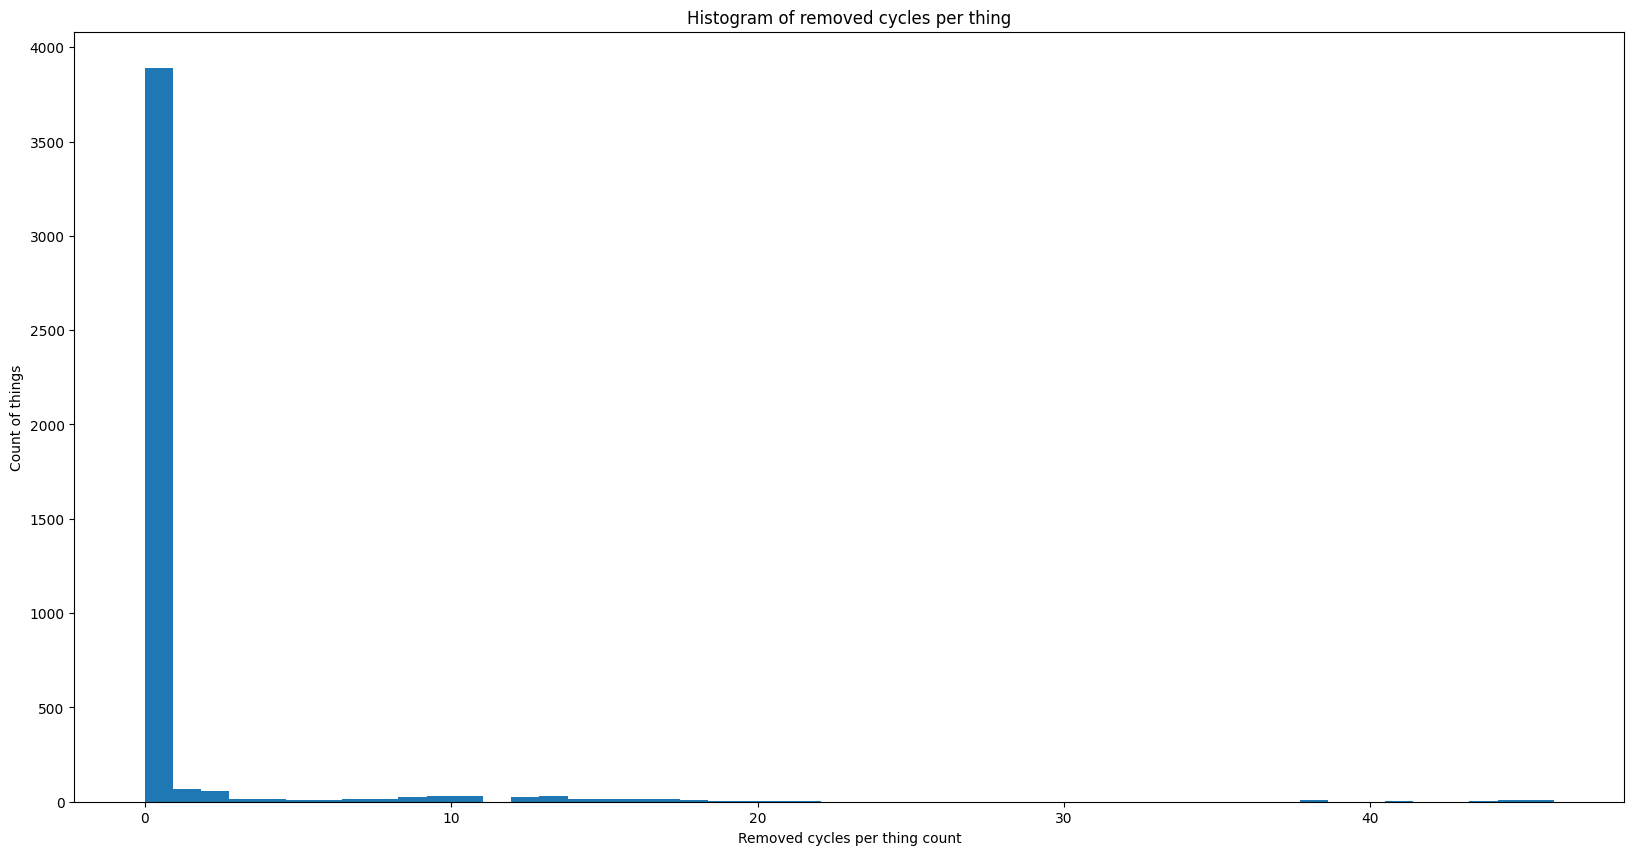

Amount of things: 19844


In [19]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import json
import matplotlib.pyplot as plt

from _config import CLEANUP_STATS_JSON_FILE
from preparations import things_provider

with open(CLEANUP_STATS_JSON_FILE, 'r') as fp:
    reconstructed_cycles = json.load(fp)
    
print("Total cycles count:", reconstructed_cycles["total_cycles_count"])
print("Total removed cycles:", reconstructed_cycles["total_removed_cycles"])
print("Total removed cycles because of invalid length:", reconstructed_cycles["total_removed_cycles_length"])
print("Total removed cycles because of invalid transitions:", reconstructed_cycles["total_removed_cycles_transitions"])
print("Total removed cycles because of missing observations:", reconstructed_cycles["total_removed_cycles_missing"])

removed_cycles_per_thing = reconstructed_cycles["removed_cycles_per_thing"]
removed_cycles = []
for thing, cycles in removed_cycles_per_thing.items():
    removed_cycles.append(cycles["total_removed_cycles"])

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(removed_cycles, bins=50)
ax.set_xlabel('Removed cycles per thing count')
ax.set_ylabel('Count of things')
ax.set_title('Histogram of removed cycles per thing')
plt.show()

# Get coordinates of the things
tp = things_provider.ThingsProvider()
things = tp.get_things()
thing_locations = {}
for thing in things:
    try:
        thing_locations[thing["name"]] = thing["Locations"][0]["location"]["geometry"]["coordinates"][0][0]
    except: 
        pass
    
# Visualize removed cycles per thing on a map
import folium

m = folium.Map(location=[51.505, -0.09], zoom_start=5)

removed_cycles_per_thing = reconstructed_cycles["removed_cycles_per_thing"]
MAX_REMOVED_CYCLES_PER_THING = 50
for thing, cycles in removed_cycles_per_thing.items():
    try:
        # based on percentage of removed cycles per thing create hex color
        percentage = cycles["total_removed_cycles"] / cycles["total_cycles_count"]
        color = '#%02x%02x%02x' % (int(255 * percentage), int(255 * (1 - percentage)), 0)
        folium.CircleMarker([thing_locations[thing][1],thing_locations[thing][0]], radius=3, color=color, popup=f"").add_to(m)
    except:
        pass

m
